Dr. Jesús Martí Gavilá. Departamento de Ingeniería Cartográfica, Geodesia y fotogrametría
<font color="blue" ><h1 align=center>PRÁCTICA 7</h1> <p> <h1 align=center> CURSO BÁSICO PYTHON: FICHERO GPX</h1></font>

<a href="http://www.upv.es/titulaciones/GTI/indexc.html"><img src = "http://www.upv.es/imagenes/marcaUPVN1.png" width =200 ></a>

<h2 align=center>Grado Tecnologías Interactivas | Tecnologías de la Información Geográfica</h2>



# TAREA
<div class="alert alert-block alert-info" style="margin-top: 20px">

<b>Realizar un análisis de rendimiento a partir de un fichero GNSS con waypoints en formato GPX.</b>
<p>
    
<h3>El resultado a obtener sera:</h3>  <p> 
   <li>
       <a>Un Dataframe en formato HTML con los siguientes campos:<p><p>
'Punto','Latitud','Longitud', 'Cota (m)', 'Hora', 'Distancia (m)','Dist_O (m)', 'Pendiente (%)', 'Velocidad (km/h)','Orientación (º)','Tiempo'</a><p>
   </li>
        
   <li>
       <a>Gráfico con los valores de distancia en el eje X y valores de pendiente y velocidad en la Y</a>
   </li>

   <li>
       <a>Mapa interactivo</a>
   </li>
</div>

# Estructura GPX e importación de librerías

In [4]:

"""
Creado Viernes 14 Oct 18:22:39 2022, @autor/es: Sento Marcos Ibarra
FORMATO EJEMPLO GPX
<wpt lat="38.968484" lon="-0.148688">
	<ele>-6.847729</ele>
	<time>2020-10-06T15:42:19Z</time>
	<name>001</name>
	<sym>Flag, Blue</sym>
</wpt>
"""
import pandas as pd
import xml.etree.cElementTree as et
import os
import math as m
from datetime import datetime
import matplotlib.pyplot as plt

# Fichero de entrada y Dataframe de salida

In [6]:
# Introducción de datos. Solicitar al usuario el nombre del fichero sin extensión.
gpx = input("Introduce nombre archivo GPX (sin extensión):")
path = os.getcwd()
pathgpx = path + '/' + gpx + ".gpx"
# Este nombre también se utilizará para crear el fichero html
pathhtml = path + '/' + gpx + ".html"


Introduce nombre archivo GPX (sin extensión): Waypoints


In [7]:
# Accedemos al XML y creamos un Dataframe con los campos arriba indicados
docxml = et.parse(pathgpx)
raiz = docxml.getroot()
puntos = len(raiz)-1
columnas = ['Punto','Latitud','Longitud', 'Cota (m)', 'Hora', 'Distancia (m)','Dist_O (m)', 'Pendiente (%)', 'Velocidad (km/h)','Orientación (º)','Tiempo']
df = pd.DataFrame(columns=columnas)

# Funciones de cálculo

In [9]:
import math as m
import pandas as pd
import matplotlib.pyplot as plt

# Cálculo de la distancia parcial y al origen. función distancias
def distancias(latA, longA, latB, longB):
    vlong = m.cos(abs(longB - longA))
    d = m.acos(m.sin(latA) * m.sin(latB) + (m.cos(latA) * m.cos(latB) * vlong))
    dr = 111.11 * d  # Convertimos a kilómetros
    return d, dr * 1000  # Devolvemos la distancia parcial en metros


In [10]:
# Cálculo del acimut. Verificar la posición del punto B. funcion orientación
def orientacion (latA, latB,d):
    AB = m.acos((m.sin (latA)-m.sin (latB)*m.cos(d))/(m.cos(latA)*m.sin(d)))
    if m.degrees(AB) < 0:
        return m.degrees(AB + 360)
    else:
        return m.degrees(AB)

In [11]:
# Cálculo de la pendiente. En %. función pendiente
def pendiente(ele1, ele2, dist):
    pendiente_percent = ((ele2 - ele1) / dist) * 100
    pendiente_grad = m.degrees(m.atan((ele2 - ele1) / dist))
    return pendiente_grad, pendiente_percent, dist



In [12]:
# Cálculo de la velocidad. función velocidad
def velocidad(time1, time2, dist):
    t1 = pd.to_datetime(time1)
    t2 = pd.to_datetime(time2)
    tiempo_total = (t2 - t1).total_seconds()  # Tiempo en segundos
    if tiempo_total == 0:
        vel_kmh = 0
    else:
        vel_kmh = (dist / 1000) / (tiempo_total / 3600)  # Velocidad en km/h
    return tiempo_total, vel_kmh
    # Supongamos que `raiz` es un objeto con datos XML y `puntos` es el número de puntos
columnas = ["ID", "Latitud", "Longitud", "Elevación (m)", "Tiempo", "Dist Parcial (m)", "Dist Acumulada (m)", "Pendiente (%)", "Velocidad (km/h)", "Acimut", "Tiempo (s)"]
df = pd.DataFrame(columns=columnas)


# Obtención de los datos de entrada y llamada a funciones

In [14]:
waypoints = range (1,puntos,1)
n = 0.00
for i in waypoints:
    # Datos del punto A
    wpt1 = raiz[i]
    lat1_g = float(wpt1.get("lat"))
    lon1_g = float(wpt1.get("lon"))
    lat1 = m.radians (lat1_g)
    lon1 = m.radians (lon1_g)
    ele1 = round(float(wpt1[0].text),3)
    time1 = wpt1[1].text
    if i == 1:
        df_1 = pd.DataFrame([[i,lat1_g,lon1_g,ele1,time1,n,n,n,n,n,n]],columns = list(columnas))
        df = pd.concat([df if not df.empty else None,df_1],ignore_index=True)  #controla si un dataframe esta vacio   
# Incrementamos puntos       
    i = i+1

# Datos del punto B
    wpt2 = raiz[i]
    lat2_g = float(wpt2.get("lat"))
    lon2_g = float(wpt2.get("lon"))
    lat2 = m.radians(lat2_g)
    lon2 = m.radians(lon2_g)
    ele2 = round(float(wpt2[0].text),3)
    time2 = wpt2[1].text

# Llamar a las diferentes funciones y añadir los datos resultantes al Dataframe
    d, dr = distancias(lat1,lon1,lat2,lon2) #Introducir los parámetros necesarios para realizar el cálculo
    acimut = orientacion(lat1,lat2,d) #Introducir los parámetros necesarios para realizar el cálculo
    peng, pend, dg = pendiente(ele1, ele2, dr) #Introducir los parámetros necesarios para realizar el cálculo
    tiempo, velkmh = velocidad(time1, time2, dr)#Introducir los parámetros necesarios para realizar el cálculo
    df_1 = pd.DataFrame([[i,lat2_g,lon2_g,ele2,time2,dg,0.00,pend,velkmh,acimut,tiempo]],columns = list(columnas))
    df = pd.concat([df,df_1],ignore_index=True )
    
    df['Dist Acumulada (m)'] = df['Dist Parcial (m)'].cumsum() # crear un comando para rellenar df['Dist_O (m)']

# Impresión y exportación de los obtenidos

In [16]:
# Imprimir los valores en formato HTML
print(df.to_html(index=False))
# Guardar el DataFrame en un archivo HTML
with open(pathhtml, "w") as file:
    file.write(df.to_html(index=False))

print(f"El archivo HTML se ha guardado en: {pathhtml}")


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>ID</th>
      <th>Latitud</th>
      <th>Longitud</th>
      <th>Elevación (m)</th>
      <th>Tiempo</th>
      <th>Dist Parcial (m)</th>
      <th>Dist Acumulada (m)</th>
      <th>Pendiente (%)</th>
      <th>Velocidad (km/h)</th>
      <th>Acimut</th>
      <th>Tiempo (s)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>38.968484</td>
      <td>-0.148688</td>
      <td>-6.848</td>
      <td>2020-10-06T15:42:19Z</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.0</td>
    </tr>
    <tr>
      <td>2</td>
      <td>38.967718</td>
      <td>-0.150631</td>
      <td>5.751</td>
      <td>2020-10-06T15:44:55Z</td>
      <td>3.284641</td>
      <td>3.284641</td>
      <td>383.573134</td>
      <td>0.075799</td>
      <td>63.111422</td>
      <td>156.0</td>
    </tr>
    <tr>
      <td>3</td>

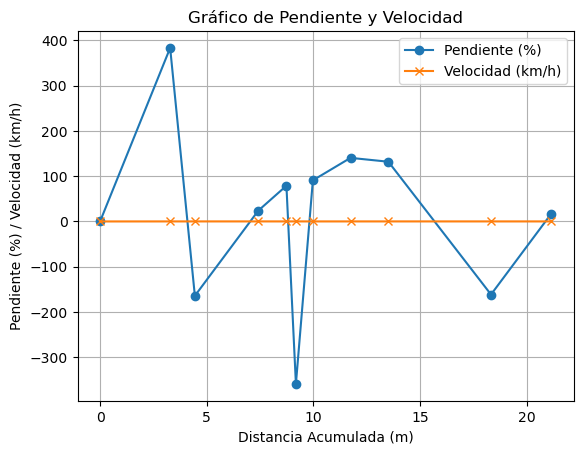

In [17]:
# Plotear el gráfico de rendimiento y guardar en JPG
fig, ax = plt.subplots()
plt.plot(df["Dist Acumulada (m)"], df['Pendiente (%)'], marker="o", label="Pendiente (%)")
plt.plot(df["Dist Acumulada (m)"], df['Velocidad (km/h)'], marker="x", label="Velocidad (km/h)")

# Leyendas, título, etiquetas de los ejes
plt.legend()
plt.title("Gráfico de Pendiente y Velocidad")
plt.xlabel("Distancia Acumulada (m)")
plt.ylabel("Pendiente (%) / Velocidad (km/h)")
plt.grid()

# Exportar como imagen JPG
plt.savefig("grafico_rendimiento.jpg")
plt.show()

# Mapa interactivo con Folium. Código ejemplo

In [19]:
#Instalar primeramente la libreria folium
......................................................................................................

#Código creación fichero decoordenadas
df.loc[:,['Latitud','Longitud']].to_csv('coordenadas.csv',header=True, index=False) #obtienes los valores de latitud y longitud y creas un fichero de coordenadas
lista_geo = pd.read_csv('coordenadas.csv').to_numpy().tolist()

#Creación del mapa interactivo
import folium
from folium import plugins
m = folium.Map()
folium.plugins.AntPath(locations = lista_geo, popup = 'Ruta 20/11/2023', reverse="True", dash_array=[10, 20], color='red', pulse_color = 'blue').add_to(m)
m.fit_bounds(m.get_bounds())
m


SyntaxError: invalid syntax (4143521956.py, line 2)